$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib notebook
# import libraries
import os
import os.path as path
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, widgets

In [2]:
# if recieve error for pytables library you should uncomment the line below and run the cell
import sys
# !conda install --yes --prefix {sys.prefix} pytables

In [ ]:
# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [ ]:
tdc, dataset = widgets.dataset_tdc_selection()
display(tdc, dataset)

$\text{Path to the dataset}$

In [5]:
tdc_model = tdc.value

dataset_name = dataset.value

p = path.abspath(path.join("", "../../../.."))

variables.init()
variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.join(p, 'tests/results/load_crop/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
# dataset name
filename = variables.path + '//' + dataset_name + '.h5'
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dldGroupStorage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc_model)
dld_masterDataframe = data_loadcrop.concatenate_dataframes_of_dld_grp(dldGroupStorage)
print('Total number of Ions:', len(dldGroupStorage[0]))

Filename>> D:\pyccapt\tests//data//data_101_Jul-27-2022_16-45_test.h5
{'apt': ['high_voltage', 'num_events', 'time_counter'], 'dld': ['AbsoluteTimeStamp', 'high_voltage', 'laser_intensity', 't', 'x', 'y'], 'tdc': ['ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7'], 'time': ['time_h', 'time_m', 'time_s']}
here {'apt/high_voltage':            values
0     2000.000000
1     1999.706055
2     1999.412109
3     1999.061157
4     1998.710083
...           ...
3803  7774.687500
3804  7774.795410
3805  7775.494629
3806  7775.308594
3807  7775.899414

[3808 rows x 1 columns], 'apt/num_events':       values
0       1098
1          0
2         19
3          0
4          0
...      ...
3803       0
3804       0
3805     295
3806       0
3807     276

[3808 rows x 1 columns], 'apt/time_counter':       values
0          0
1          1
2          2
3          3
4          4
...      ...
3803    3803
3804    3804
3805    3805
3806    3806
3807    3807

[3808 rows x 1 columns], 'dld/AbsoluteTimeSt

$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

<IPython.core.display.Javascript object>


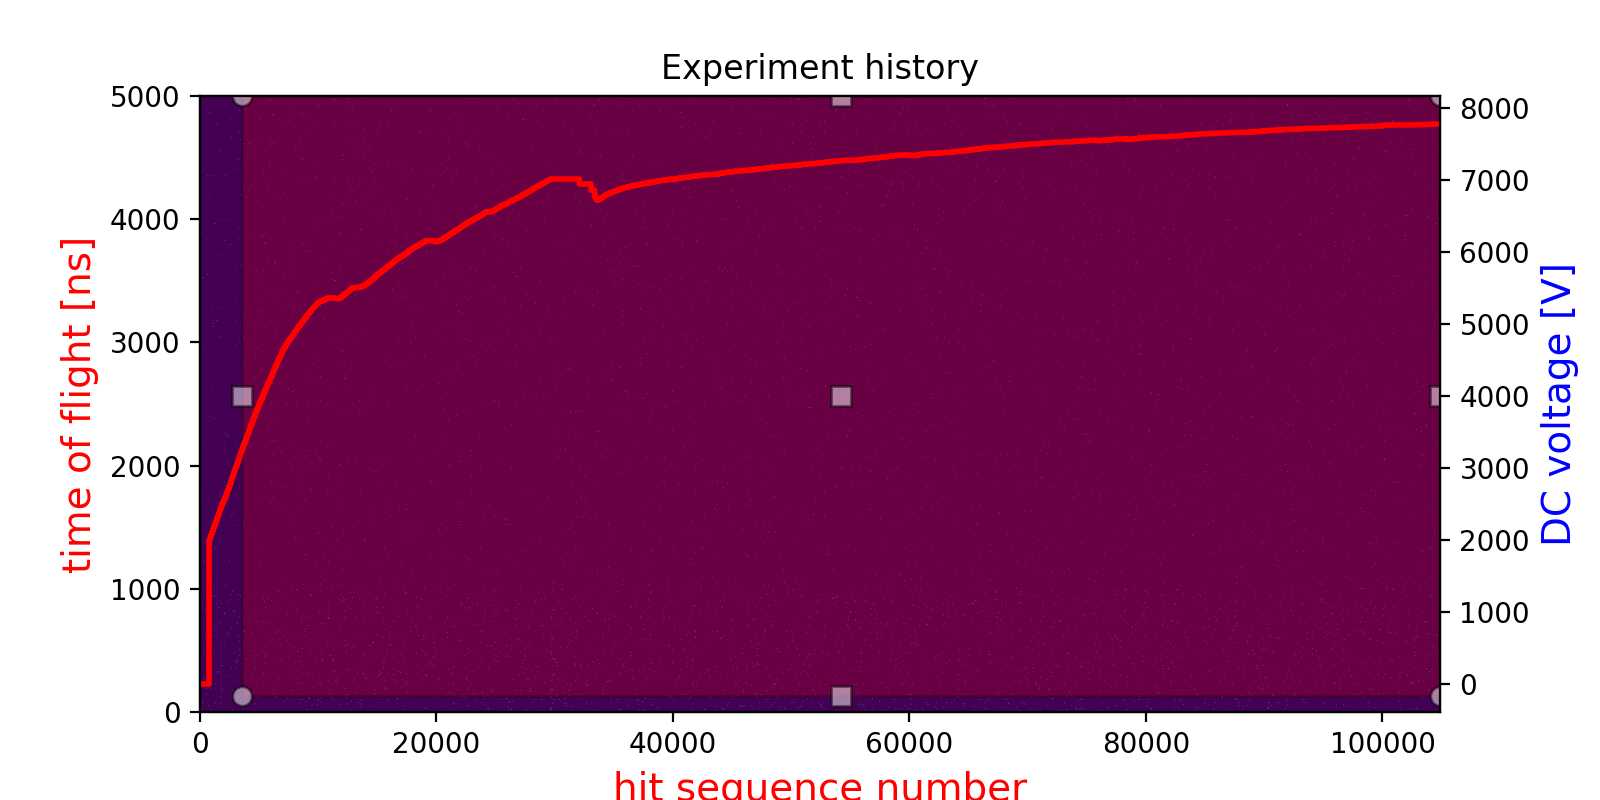

In [6]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, save_name = variables.result_path + '//ex_hist_' + dataset_name)



$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [9]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_masterDataframe)

Min Idx: 3545.508770161294 Max Idx: 104872.0


<IPython.core.display.Javascript object>


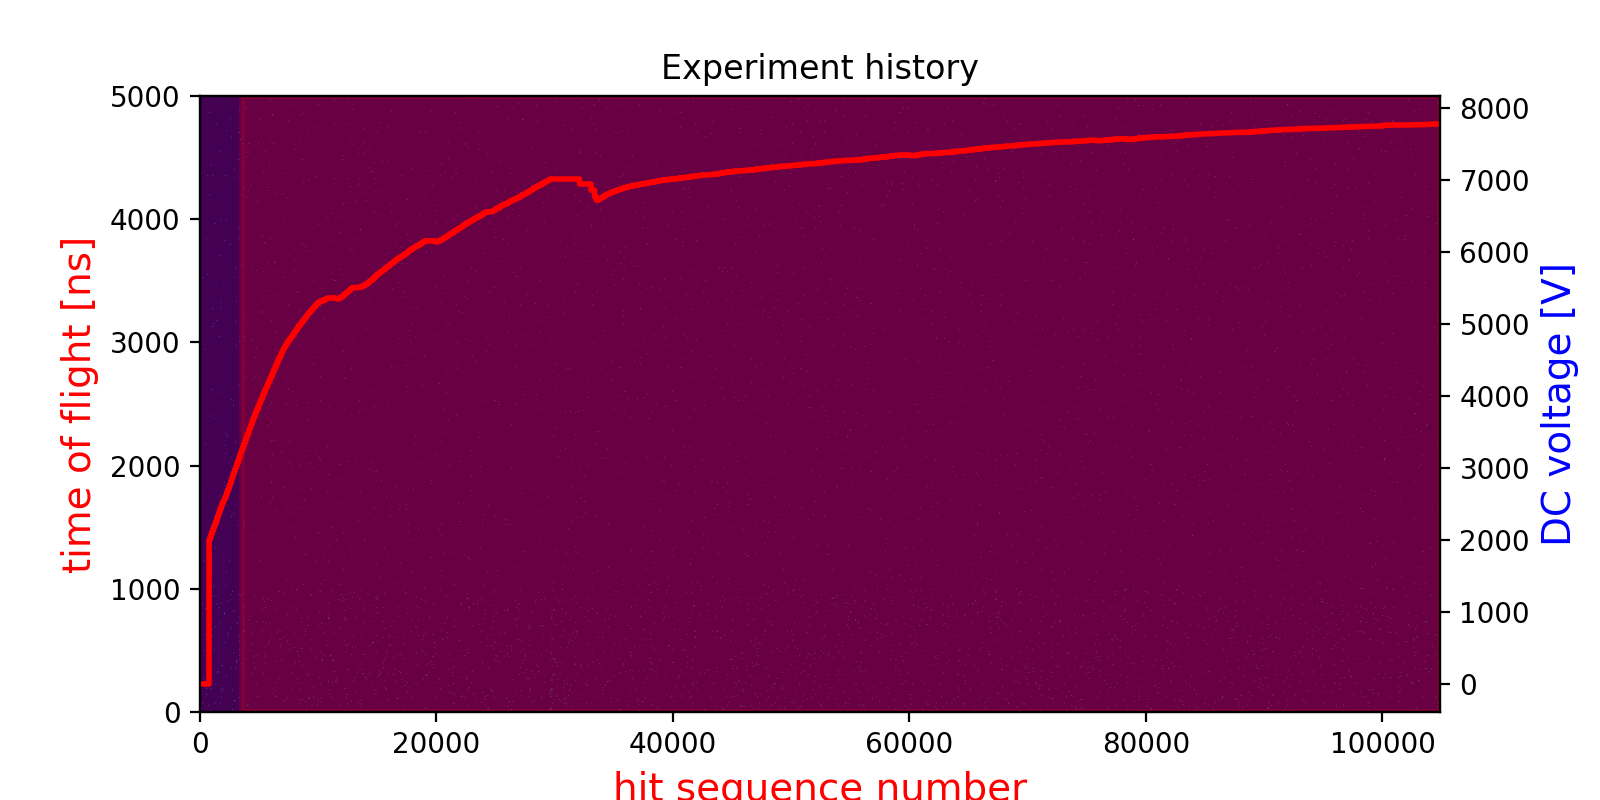

In [10]:
# Plot and selected experiment history
fig1, ax1 = plt.subplots(figsize=(8, 4))
data_loadcrop.plot_graph_for_dld_high_voltage(ax1, dldGroupStorage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

<IPython.core.display.Javascript object>


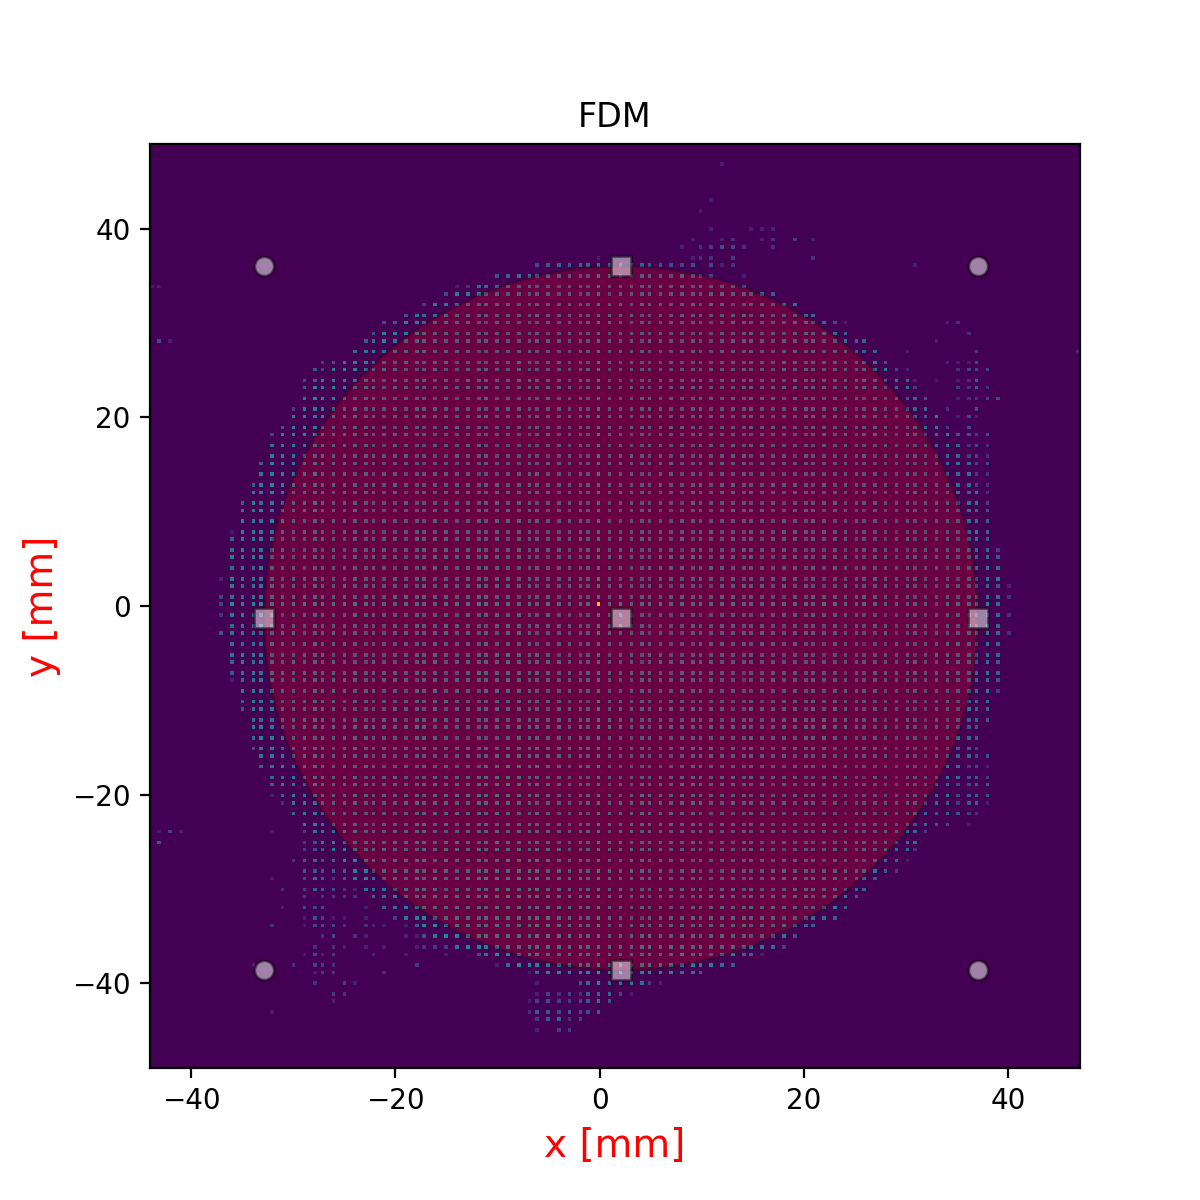

09-08-2022 10:06:14 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_data_101_Jul-27-2022_16-45_test
09-08-2022 10:06:14 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_data_101_Jul-27-2022_16-45_test
09-08-2022 10:06:14 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_data_101_Jul-27-2022_16-45_test


In [11]:
# Plot and select the FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_crop_FDM(ax1, fig1, data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

<IPython.core.display.Javascript object>


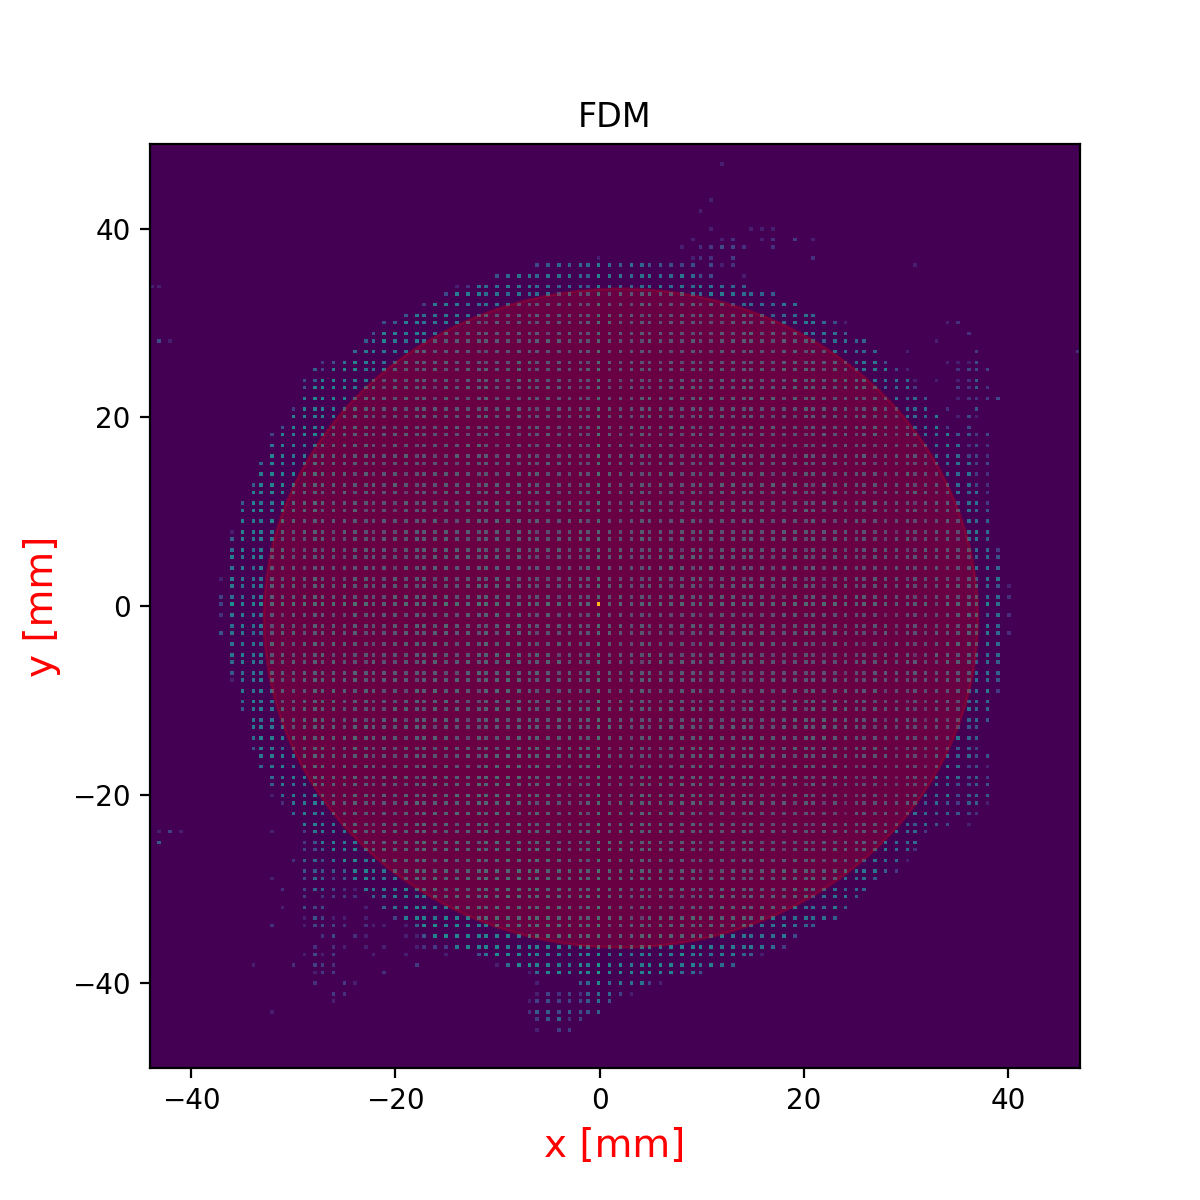

09-08-2022 10:06:51 | INFO | Circle selector Called
09-08-2022 10:06:51 | INFO | Circle selector Called
09-08-2022 10:06:51 | INFO | Circle selector Called
x: 2.0794522849462425 y: -1.2844345018349017 roi: 34.93225806451614
09-08-2022 10:06:51 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_c_data_101_Jul-27-2022_16-45_test
09-08-2022 10:06:51 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_c_data_101_Jul-27-2022_16-45_test
09-08-2022 10:06:51 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_c_data_101_Jul-27-2022_16-45_test


In [12]:
# plot selected area in FDM
fig1, ax1 = plt.subplots(figsize=(6,6))
data_loadcrop.plot_FDM_after_selection(ax1, fig1, data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name)

$\text {The final selected data after processing is shown below.}$

<IPython.core.display.Javascript object>


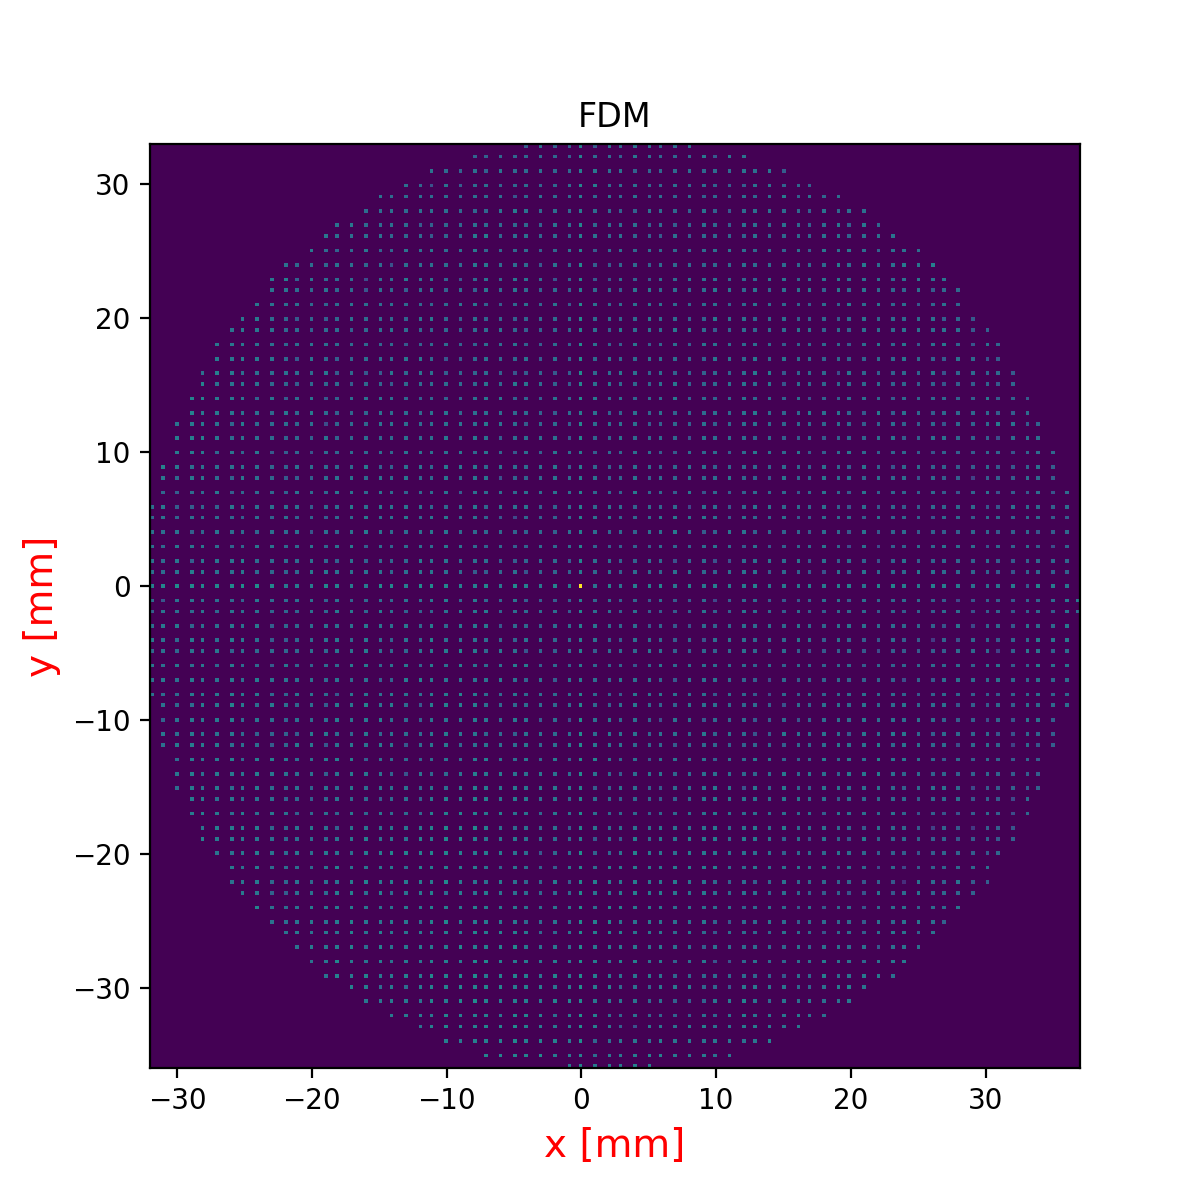

09-08-2022 10:06:58 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_crop_data_101_Jul-27-2022_16-45_test
09-08-2022 10:06:58 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_crop_data_101_Jul-27-2022_16-45_test
09-08-2022 10:06:58 | INFO | Plot saved by the name D:\pyccapt\tests/results/load_crop/data_101_Jul-27-2022_16-45_test//FDM_crop_data_101_Jul-27-2022_16-45_test


In [13]:
# Crop and plot the dataset
fig1, ax1 = plt.subplots(figsize=(6,6))
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_FDM(ax1, fig1, data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name)

$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [14]:
# save the dataset to hdf5 file
name = os.path.splitext(filename)[0]
data_loadcrop.save_croppped_data_to_hdf5(data_crop_FDM, dld_masterDataframe, savename, tdc_model)

09-08-2022 10:07:00 | INFO | tofCropLossPct 22
09-08-2022 10:07:00 | INFO | tofCropLossPct 22
09-08-2022 10:07:00 | INFO | tofCropLossPct 22


In [15]:
# add the dataset to hdf5 file
data_loadcrop.add_croppped_data_to_hdf5(filename, data_crop_FDM, dld_masterDataframe, tdc_model)

tofCropLossPct 22.28695660465515
